# OneModel: an open-source SBML modeling tool focused on accessibility, simplicity and modularity

## Install OneModel and dependencies needed for the workshop

In [ ]:
# Install onemodel.
!pip install -I --no-cache-dir https://github.com/fernandonobel/onemodel/archive/jupyter.zip
    
# Install roadrunner for SBML simulations.
!pip install libroadrunner

# Download examples.
!wget https://raw.githubusercontent.com/fernandonobel/onemodel/develop/examples/ex01_simple_gene_expression.one
!wget https://raw.githubusercontent.com/fernandonobel/onemodel/develop/examples/ex03_protein_constitutive.one
!wget https://raw.githubusercontent.com/fernandonobel/onemodel/develop/examples/ex05_protein_induced.one

In [1]:
import onemodel
import roadrunner

# Custom plot for roadrunner.
# Plots each state in a different plot.
def plot(rr):

    import pylab as p

    result = rr.getSimulationData()

    if result is None:
        raise Exception("no simulation result")

    # assume result is a standard numpy array

    selections = rr.timeCourseSelections

    if len(result.shape) != 2 or result.shape[1] != len(selections):
        raise Exception("simulation result columns not equal to number of selections,"
                        "likely a simulation has not been run")

    times = result[:,0]

    for i in range(1, len(selections)):
        series = result[:,i]
        name = selections[i]
            
        fig, ax = p.subplots()
        ax.plot(times, series, label=str(name))
        ax.legend()
        
# Add the custom plot to roadrunner.
roadrunner.RoadRunner.plot = plot

----
## PART 1: How to model biological processes using OneModel

### Exercise 01: The OneModel REPL (Read-Eval-Print Loop)

OneModel has an interactive command-line REPL (read-eval-print loop).

**Task:** Try to use the OneModel REPL build a model interactively.

**Time limit:** 5 minutes.

For example, 

```
my_variable = 10
parameter a = 0
```

**Supporting material:** Link to the documentation.

**Note:** use only single-line commands. To use a multiline command (i.e. a parameter block) you have to introduce manually intro lines using `;`

For example,

```
# Multi-line version of a parameter block.
parameter
  foo = 10
  bar = 20
end

# Singe-line parameter block.
parameter; foo = 10; bar = 20; end

# Even easier just use regular single-line commands.
parameter foo = 10
parameter bar = 20
```

In [2]:
model = onemodel.shell()

print("\n=== Built-in and user-defined variables =============")
print(model)

print("\n=== SBML representation of the model ================")
sbml = model.get_SBML_string()
print(sbml)

OneModel v1.0.0
Documentation: https://onemodel.readthedocs.io/

one> parameter k_A = 1
one> species A = 0
one> rule R1: der(A) := k_A - A
one> exit()

=== Built-in and user-defined variables =============
Names and values
----------------

R1 : <rate-rule eq='der(A) := k_A - A'>
A : <species initial_value=0>
k_A : <parameter value=1>
locals : <builtin-function>
globals : <builtin-function>
print : <builtin-function>
exit : <builtin-function>
__file__ : '/home/nobel/Sync/projects/python/onemodel/examples/iwbda-22'
__exit__ : 1
__name__ : '__main__'


=== SBML representation of the model ================
<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version2/core" level="3" version="2">
  <model id="main" name="main" substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listO

### Exercise 02: Define models using scripts

Instead of using the OneModel REPL, we can define models permanently using scripts.

In [3]:
model_code = """
parameter 
    k = 20
    d = 0.1
end

species x = 0

rule R1: der(x) := k - d*x
"""

model = onemodel.evaluate(model_code)

print(model)

Names and values
----------------

R1 : <rate-rule eq='der(x) := k - d*x'>
x : <species initial_value=0>
d : <parameter value=0.1>
k : <parameter value=20>
locals : <builtin-function>
globals : <builtin-function>
print : <builtin-function>
exit : <builtin-function>
__file__ : '/home/nobel/Sync/projects/python/onemodel/examples/iwbda-22'
__exit__ : False
__name__ : '__main__'



### Exercise 04: Load a script from a file

Google Colab only allows to edit files with .txt or .py extensions. OneModel uses .one as extensions, so to bypass this limitation we can use "%%file" to directly write text into a file.

We will use this special command to write files with OneModel syntax. 

When editint the contents of the following cell, use ctrl+intro to write into the file.

In [4]:
%%file test_model.one

species
    A = 0
    B = 0
    C = 0
end

parameter k = 1

reaction J1: A + B -> C ; k*A*B

Overwriting test_model.one


We can read the contents of a file in two ways:

1. You can download the file from the left pane and open it localy with a text editor.
2. Or, you can just execute the following command to print the contents of the file.

In [5]:
%cat test_model.one


species
    A = 0
    B = 0
    C = 0
end

parameter k = 1

reaction J1: A + B -> C ; k*A*B


Now, we can use OneModel to directly read from the file `test_model.one` where we have defined our model. This is the best way to use OneModel

In [6]:
filename = "test_model.one"

model = onemodel.load(filename)

print(model)

Names and values
----------------

J1 : <reaction eq='A + B -> C ; k*A*B'>
k : <parameter value=1>
C : <species initial_value=0>
B : <species initial_value=0>
A : <species initial_value=0>
locals : <builtin-function>
globals : <builtin-function>
print : <builtin-function>
exit : <builtin-function>
__file__ : '/home/nobel/Sync/projects/python/onemodel/examples/iwbda-22/test_model.one'
__exit__ : False
__name__ : '__main__'



### Exercise 05: Simulate the model using `roadrunner`

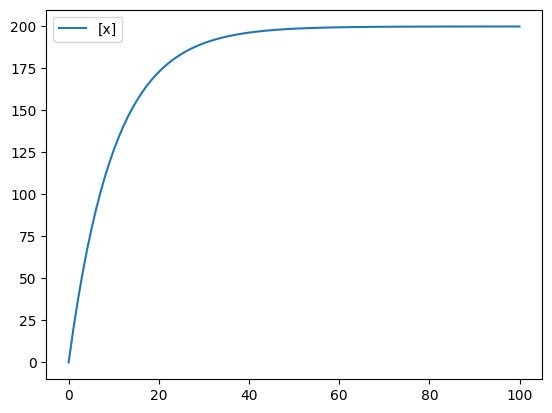

In [7]:
model_code = """
parameter 
    k = 20
    d = 0.1
end

species x = 0

rule R1: der(x) := k - d*x
"""

model = onemodel.evaluate(model_code)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 100, 100)
rr.plot()

### Exercise 06: Model constitutive protein expression
$$\require{mhchem}$$ 
**Set of reactions:**

* mRNA transcription: $\ce{\emptyset->[k_m] mRNA}$
* mRNA degradation: $\ce{mRNA ->[d_m] \emptyset}$
* Protein translation: $\ce{mRNA ->[k_p] mRNA + protein}$
* Protein degradation: $\ce{protein ->[d_p] \emptyset}$

**Set of parameters:**

* Transcription rate: $k_m$
* mRNA degradation rate: $d_m$
* Translation rate: $k_p$
* Protein degradation rate: $d_p$

**Set of species:**

* Concentration of mRNA: $mRNA$
* Concentration of protein: $protein$

In [ ]:
model_code = """
# TODO: Write your model here.

"""

model = onemodel.evaluate(model_code)

print(model)

----
## PART 2: How to reuse and extend your models using OneModel

### Exercise 07: Resue modeles using the keyword `model`

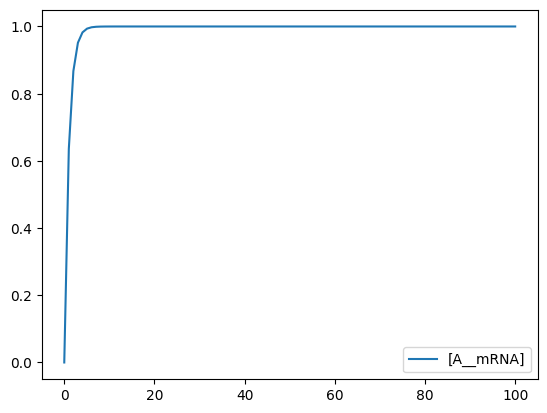

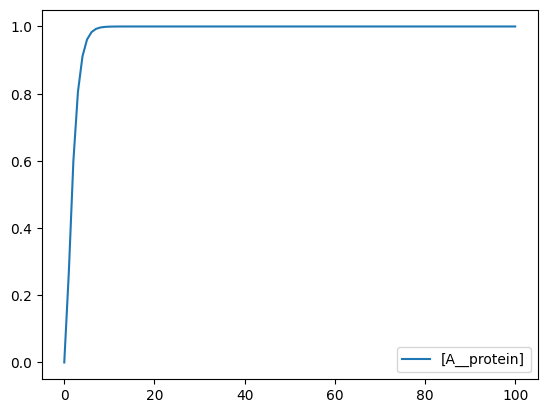

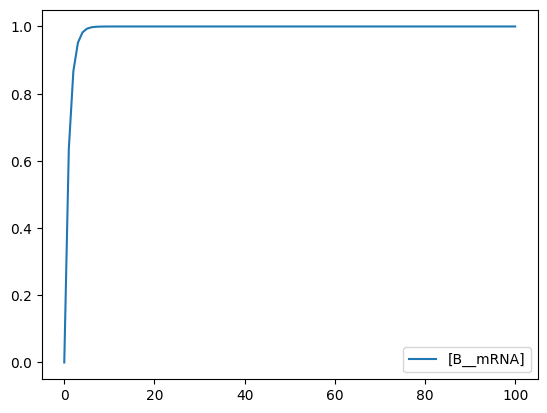

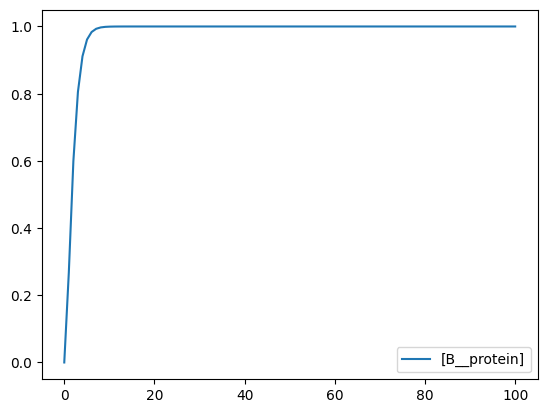

In [8]:
model_code = """
model ProteinConstitutive
    species 
        mRNA=0
        protein=0
    end
  
    parameter
        k_m=1
        d_m=1
        k_p=1
        d_p=1
    end
  
    reaction
        0 -> mRNA ; k_m          
        mRNA -> 0 ; d_m*mRNA    
        mRNA -> mRNA + protein ; k_p*mRNA
        protein -> 0 ; d_p*protein
    end
end

A = ProteinConstitutive()
B = ProteinConstitutive()
"""

model = onemodel.evaluate(model_code)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
result = rr.simulate(0, 100, 100)

rr.plot()

### Exercise 08: Extend a model

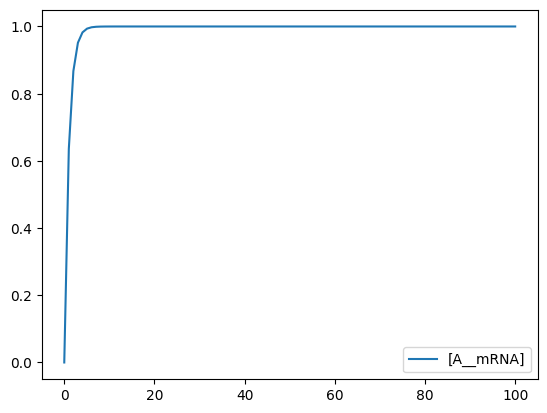

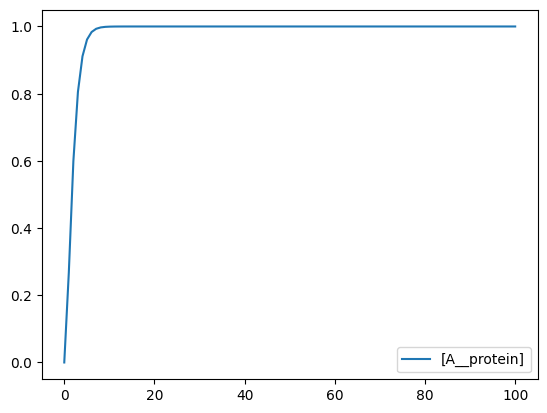

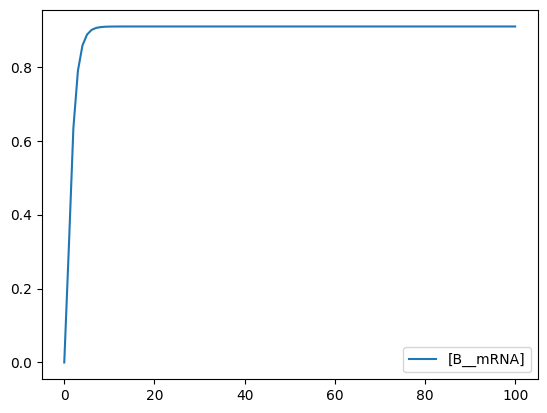

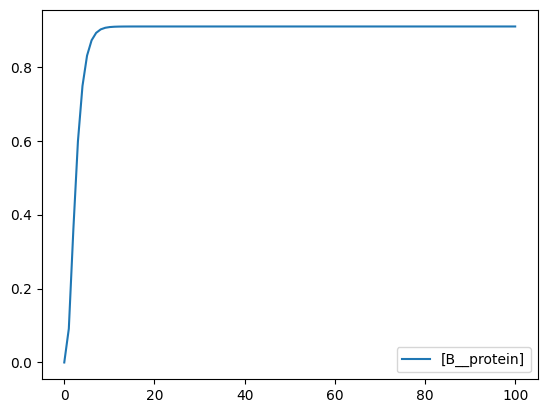

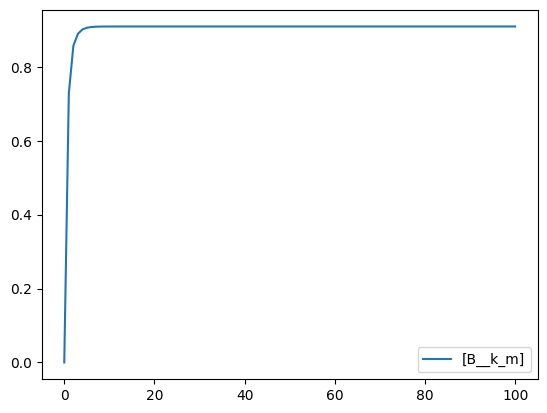

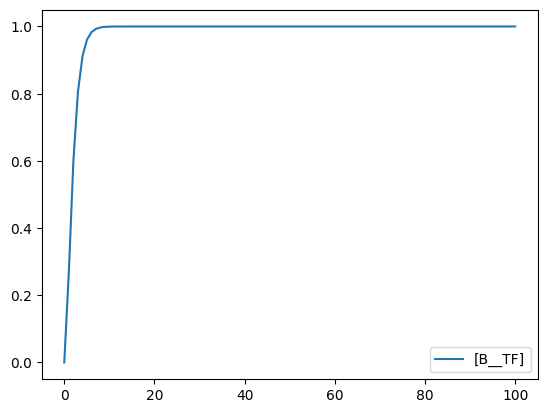

In [10]:
model_code = """
model ProteinConstitutive
    species 
        mRNA=0
        protein=0
    end
  
    parameter
        k_m=1
        d_m=1
        k_p=1
        d_p=1
    end
  
    reaction
        0 -> mRNA ; k_m          
        mRNA -> 0 ; d_m*mRNA    
        mRNA -> mRNA + protein ; k_p*mRNA
        protein -> 0 ; d_p*protein
    end
end

model ProteinInduced
    extends ProteinConstitutive
    
    species 
        TF = 0
        k_m = 0 
    end
    
    parameter h = 0.1
    
    rule k_m := TF/(TF + h)
end

A = ProteinConstitutive()
B = ProteinInduced()

rule B.TF := A.protein
"""

model = onemodel.evaluate(model_code)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 100, 100)
rr.plot()

### Exercise 09: Model the antithetic controller

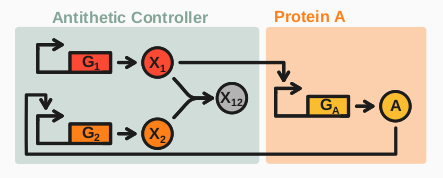

In [11]:
model_code = """
from ex05_protein_induced import ProteinConstitutive
from ex05_protein_induced import ProteinInduced

model AntitheticController

  z1 = ProteinConstitutive()
  z2 = ProteinInduced()
  x  = ProteinInduced()

  parameter gamma = 1         # Antithetical sequestration rate.

  reaction
    # We have to add the antithetical reaction.
    # Note that we can access species inside objects using '.' operator.
    z1.protein + z2.protein -> 0 ; gamma*z1.protein*z2.protein
  end

  rule
    x.TF  := z1.protein  # Set z1 as the transcription factor of x. 
    z2.TF := x.protein   # Set x as the transcription factor of z2.
  end
end

circuit = AntitheticController()
"""

model = onemodel.evaluate(model_code)

sbml = model.get_SBML_string()

rr = roadrunner.RoadRunner(sbml)
results = rr.simulate(0, 100, 100)
rr.plot()

IndexError: list index out of range

----
## PART 3: How to import and use other people's models using OneModel

### Exercise 10: Install a model from GitHub

### Exercise 11: Add the expression of a exogenous protein to the host-aware model for *E.coli*